# MODELO DE REDUCCIÓN DE PERDIDAS

**Objetivo:** Reducir perdidas por fraude en las reclamaciones de siniestro

Para la elaboración del modelo se cuenta con una base de datos con 15,420 registros y 33 variables

In [1]:
import pandas as pd
import numpy as np
import sys  
import os


pd.options.display.max_columns = None
directory = os.path.abspath('..')
sys.path.insert(0,directory)

In [2]:
# Open connection to database
from dbConnectionManager import Db_connection_manager

manager_connection = Db_connection_manager()
manager_connection.open()

connection successful


In [3]:
#manager_connection.close()

In [4]:
# execute query and save data into var df
salida_esperada = manager_connection.execute_query('''
  SELECT DISTINCT monthh,weekofmonth,dayofweek,
ROUND(SUM(fraudfound_p) OVER(PARTITION BY monthh)::numeric/COUNT(fraudfound_p) 
	  OVER(PARTITION BY monthh)*100,2) AS percentage_fraud_month,
ROUND(SUM(fraudfound_p) OVER(PARTITION BY monthh,weekofmonth)::numeric/COUNT(fraudfound_p) 
	  OVER(PARTITION BY monthh, weekofmonth)*100,2) AS percentage_fraud_month_week,
ROUND(SUM(fraudfound_p) OVER(PARTITION BY monthh,weekofmonth,dayofweek)::numeric/COUNT(fraudfound_p) OVER(PARTITION BY monthh,weekofmonth,dayofweek)*100,2) AS percentage_fraud_month_week_day
FROM public.fraudes
ORDER BY monthh, weekofmonth;
''')

pd.DataFrame(salida_esperada)

,monthh,weekofmonth,dayofweek,percentage_fraud_month,percentage_fraud_month_week,percentage_fraud_month_week_day
0,Apr,1,Tuesday,6.25,6.64,4.08
1,Apr,1,Monday,6.25,6.64,8.33
2,Apr,1,Saturday,6.25,6.64,5.77
3,Apr,1,Sunday,6.25,6.64,2.33
4,Apr,1,Friday,6.25,6.64,9.52
...,...,...,...,...,...,...
389,Sep,4,Saturday,6.13,4.26,5.00
390,Sep,5,Wednesday,6.13,5.56,9.09
391,Sep,5,Thursday,6.13,5.56,2.17
392,Sep,5,Friday,6.13,5.56,6.67


## Lectura y tratamiento de datos

In [5]:
# execute query and save data into var df
df = manager_connection.execute_query('''
select *
from fraudes;
''')

df = pd.DataFrame(df)
df.head()

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,age,fault,policytype,vehiclecategory,vehicleprice,fraudfound_p,policynumber,repnumber,deductible,driverrating,days_policy_accident,days_policy_claim,pastnumberofclaims,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [6]:
print(df.shape)
df.info(show_counts=True)
# fraudfound_p
# weekofmonth
# weekofmonthclaimed
# fraudfound_p
# repnumber
# driverrating

# policynumber # eliminar



(15420, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   monthh                15420 non-null  object
 1   weekofmonth           15420 non-null  object
 2   dayofweek             15420 non-null  object
 3   make                  15420 non-null  object
 4   accidentarea          15420 non-null  object
 5   dayofweekclaimed      15420 non-null  object
 6   monthclaimed          15420 non-null  object
 7   weekofmonthclaimed    15420 non-null  object
 8   sex                   15420 non-null  object
 9   maritalstatus         15420 non-null  object
 10  age                   15420 non-null  int64 
 11  fault                 15420 non-null  object
 12  policytype            15420 non-null  object
 13  vehiclecategory       15420 non-null  object
 14  vehicleprice          15420 non-null  object
 15  fraudfound_p          15

Se elimina la variable policynumber, ya que esta no trae informacion relevante

In [7]:
df.drop('policynumber', axis=1, inplace=True)


Se analiza cuantos valores unicos hay por columna, para saber que tan relevante es cada una de estas

In [8]:
for i in df.columns:
        print(i, ":", df[i].nunique())

monthh : 12
weekofmonth : 5
dayofweek : 7
make : 19
accidentarea : 2
dayofweekclaimed : 8
monthclaimed : 13
weekofmonthclaimed : 5
sex : 2
maritalstatus : 4
age : 66
fault : 2
policytype : 9
vehiclecategory : 3
vehicleprice : 6
fraudfound_p : 2
repnumber : 16
deductible : 4
driverrating : 4
days_policy_accident : 5
days_policy_claim : 4
pastnumberofclaims : 4
ageofvehicle : 8
ageofpolicyholder : 9
policereportfiled : 2
witnesspresent : 2
agenttype : 2
numberofsuppliments : 4
addresschange_claim : 5
numberofcars : 5
yearr : 3
basepolicy : 3


Se cambia el formato de las variables fraudfound_p, yearr y driverrating, ya que estas aplican mas para ser una variable categorica debido a la distribucion de los datos. La variable deductible, la cual hace referencia al costo del seguro se pensaba en un inicio que era una variable cuantitativa, pero al ver que solo tiene 4 valores correspondientes aplica mas a ser una variable categorica asi que tambien cambiamos su clase.

In [9]:
df[['fraudfound_p','yearr','driverrating','deductible']] = df[['fraudfound_p','yearr','driverrating','deductible']].astype(str)


## ahora se llama fraudfound_p_1

Finalmente que damos solo con la variable numerica deductible, la cual hace referencia al costo del seguro

# Análisis descriptivo de los datos

In [10]:
df.describe()

,age
count,15420.000000
mean,39.855707
std,13.492377
min,0.000000
25%,31.000000
50%,38.000000
75%,48.000000
max,80.000000


In [11]:
import matplotlib.pyplot as plt

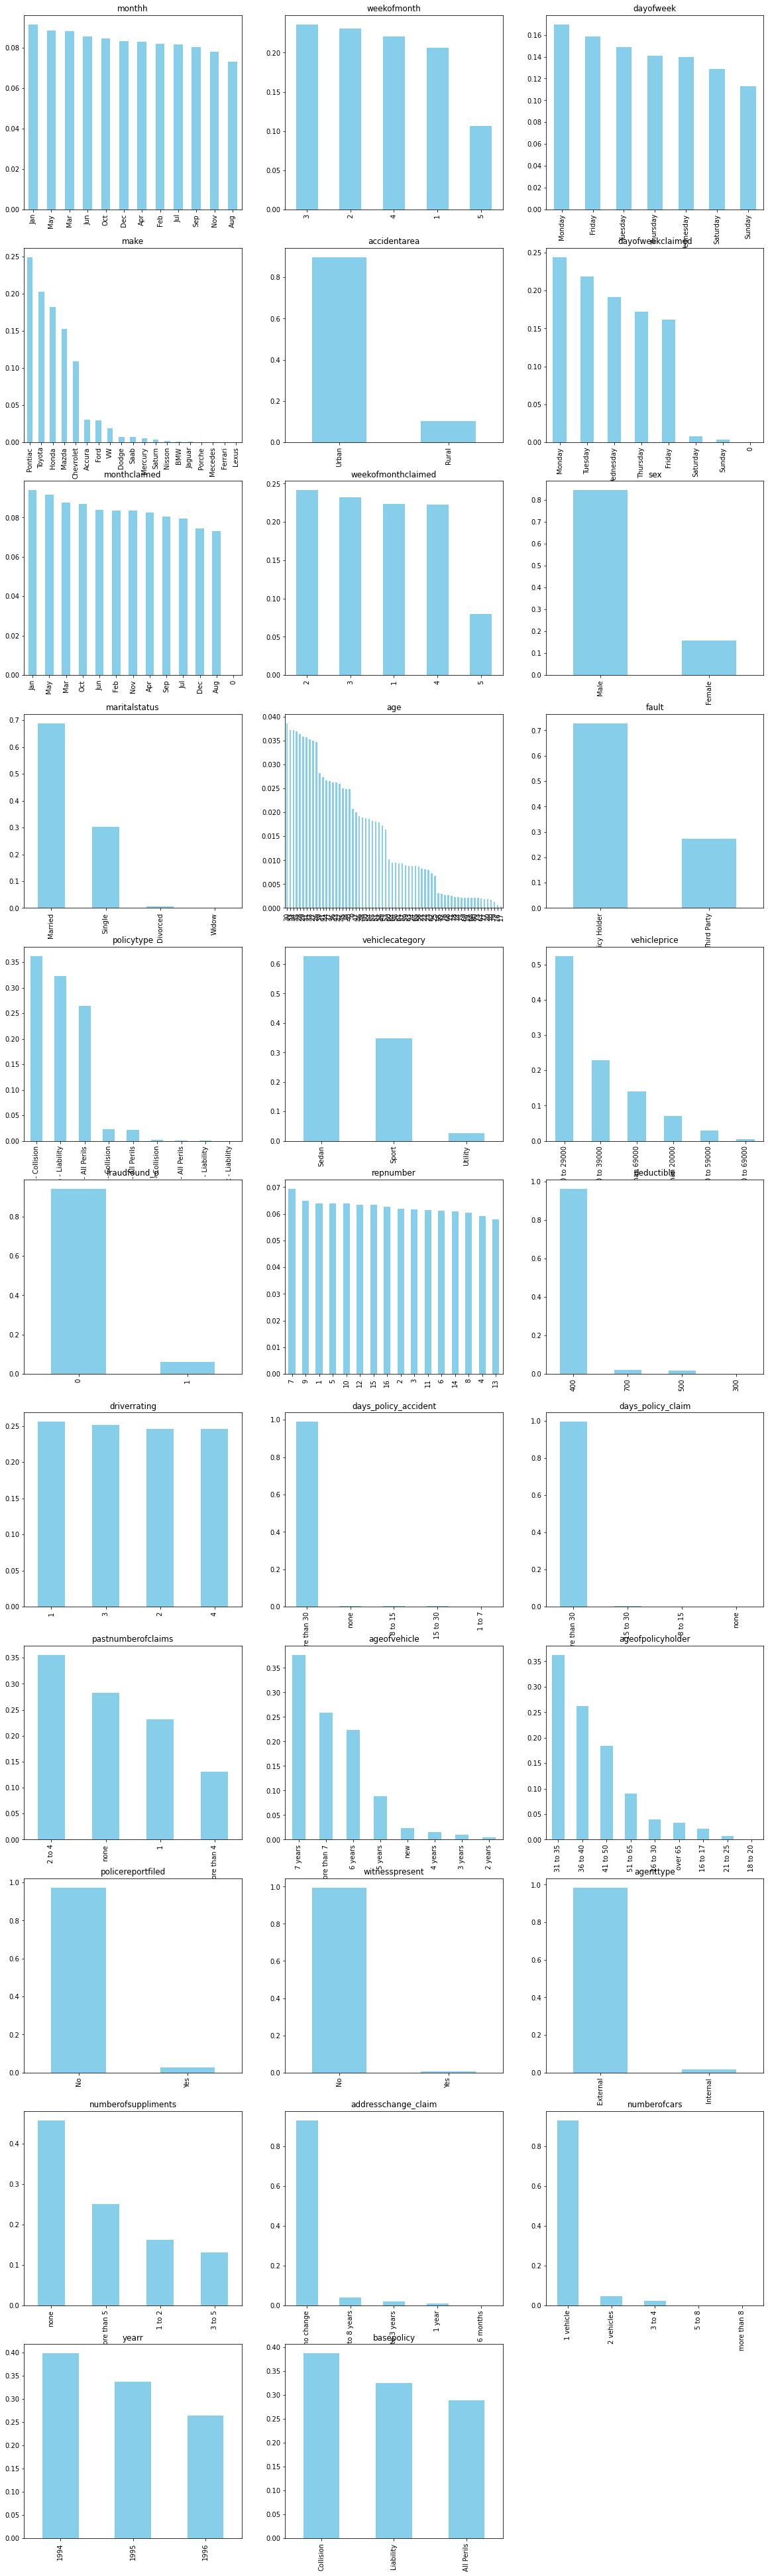

In [12]:
variables = df.columns
        
plt.figure(figsize=(20,70))
for i,var in enumerate(variables):
    plt.subplot(11,3,i+1)
    df[var].value_counts(normalize=True).plot(kind='bar',color="skyblue", title=var)

### variable de respuesta con las variables dependientes

La variable policytype esta relacionada con el tpo de seguro y con el tipo de vehiculo, ya que es una combinacion de ambas. y como la variable policytype, presenta que el 95% los vehiculos estan relacionados con tipo de poliza con vehiculos Sedan entonces no se tendra en cuenta esta variable para el modelo.

In [13]:
import seaborn as sns

<Figure size 1440x5040 with 0 Axes>

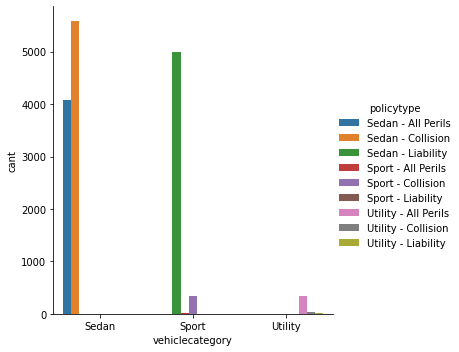

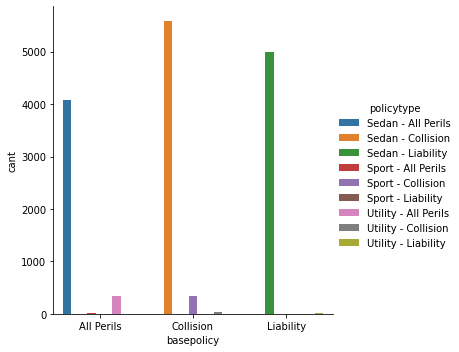

In [14]:
variables = ['vehiclecategory','basepolicy']#df.columns[:6]
plt.figure(figsize=(20,70))
for i,var in enumerate(variables):
    dfgraf = df.groupby(['policytype',var]).size().reset_index().rename({0:'cant'},axis=1)
    dfgraf = pd.DataFrame(dfgraf)
    sns.catplot(data=dfgraf, kind="bar", x=var, y= 'cant', hue="policytype")
    plt.show()

PoliceReportFiled, WitnessPresent, agenttype Las variables  presentan un comportamiento similar en los desbalanceos pero al parecer no comparten los mismos usuarios en todos los casos. sin embargo al estar tan desbalanceadas para este caso no seran tenidas en cuenta para el modelo

In [15]:
print("####")
print(pd.crosstab(df['policereportfiled'], df['witnesspresent'],normalize=True))
print("####")
print(pd.crosstab(df['policereportfiled'], df['agenttype'], normalize=True))
print("####")
print(pd.crosstab(df['witnesspresent'], df['agenttype'], normalize=True))


####
witnesspresent           No       Yes
policereportfiled                    
No                 0.969196  0.003048
Yes                0.025162  0.002594
####
agenttype          External  Internal
policereportfiled                    
No                 0.957523  0.014721
Yes                0.026848  0.000908
####
agenttype       External  Internal
witnesspresent                    
No              0.978923  0.015435
Yes             0.005447  0.000195


Days_Policy_Accident y Days_Policy_Claim parecen tener una asociación

In [16]:
pd.crosstab(df['days_policy_accident'], df['days_policy_claim'],normalize=True)

days_policy_claim,15 to 30,8 to 15,more than 30,none
days_policy_accident,,,,
1 to 7,0.000389,0.000065,0.000454,0.000000
15 to 30,0.001038,0.000000,0.002140,0.000000
8 to 15,0.001297,0.000843,0.001427,0.000000
more than 30,0.000195,0.000000,0.988521,0.000065
none,0.000713,0.000454,0.002399,0.000000


Para la variable age se tienen 320 usuarios sin registro, se pensaba que había una relacion directa entre esta variable esta con la edad del dueno del seguro, al ver los datos paree que cuando el dueno de la poliza esta en un rango de edad, la edad de la persona que hace la denuncia esta en un rango menor, sin embargo esto solo se ve en unas categorias.

POr tanto para el caso de los datos faltantes en la variable age se completaran con la moda en esta variable. sin embargo a futuro se pueden evaluar otras formas de completar esta.

In [17]:
pd.crosstab(df['ageofpolicyholder'], df['age'])

age,0,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
ageofpolicyholder,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16 to 17,320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18 to 20,0,9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21 to 25,0,0,0,48,32,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26 to 30,0,0,0,0,0,0,127,125,122,135,104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31 to 35,0,0,0,0,0,0,0,0,0,0,0,535,540,560,552,596,550,544,574,573,569,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36 to 40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,406,410,384,435,383,423,401,404,411,386,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41 to 50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,296,308,291,265,290,279,276,253,288,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51 to 65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,146,144,134,138,156,145,112,136,146,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
over 65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,31,32,32,27,40,45,32,35,34,42,29,35,20,32


<AxesSubplot:xlabel='ageofpolicyholder'>

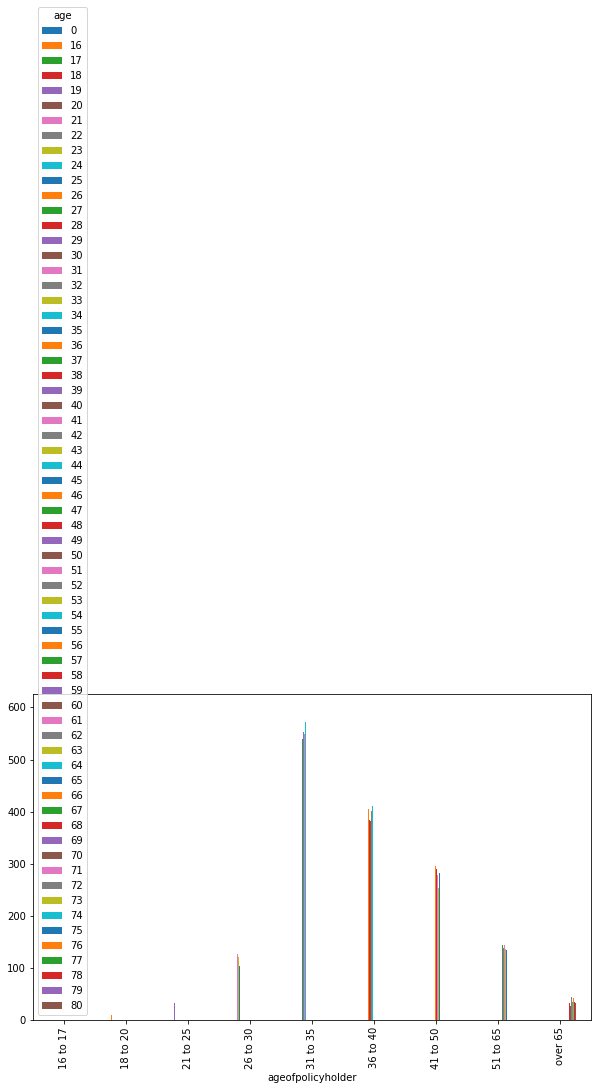

In [18]:
pd.crosstab(df['ageofpolicyholder'], df['age']).plot(kind='bar', figsize =(10,6))

Comportamiento de las variables osciodemograficas con la variable de respuesta si el accidente fue fraudulento o no

En los graficos no se observa si al accidente ser fraudulento alguna variable destaque mas, ya que esta presenta un desbalanceo grande

<Figure size 1440x5040 with 0 Axes>

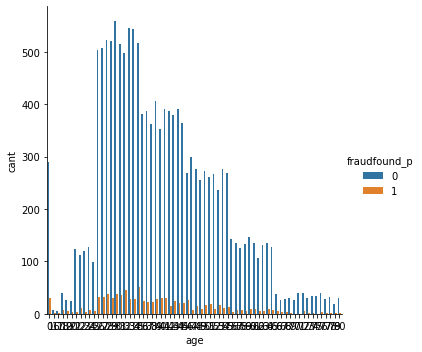

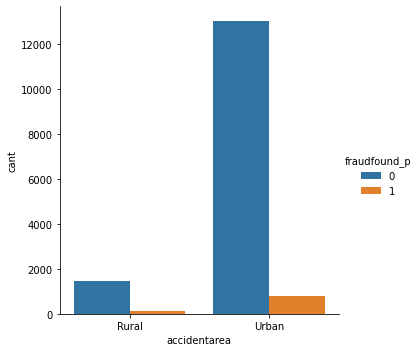

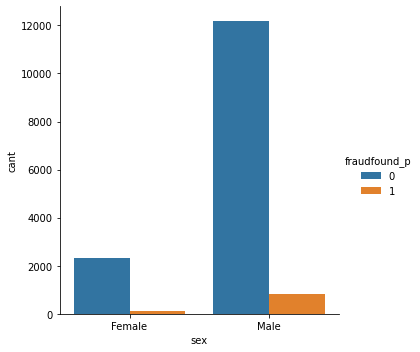

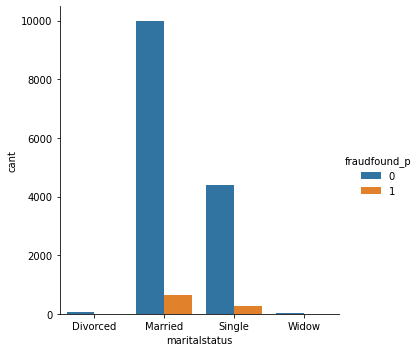

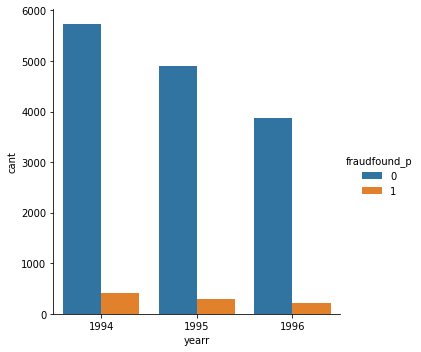

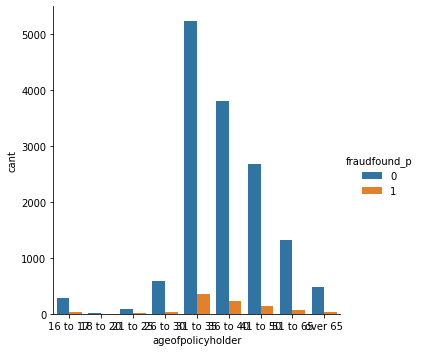

In [19]:
variables = ['age', 'accidentarea', 'sex', 'maritalstatus', 'yearr', 'ageofpolicyholder']#df.columns[:6]
plt.figure(figsize=(20,70))
for i,var in enumerate(variables):
    dfgraf = df.groupby(['fraudfound_p',var]).size().reset_index().rename({0:'cant'},axis=1)
    dfgraf = pd.DataFrame(dfgraf)
    sns.catplot(data=dfgraf, kind="bar", x=var, y= 'cant', hue="fraudfound_p")
    plt.show()

<Figure size 1440x5040 with 0 Axes>

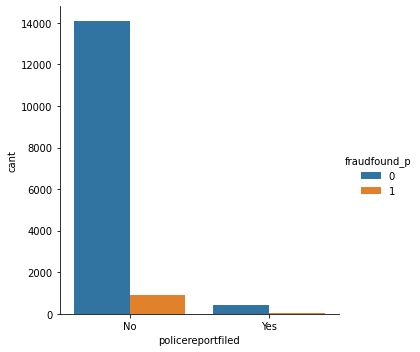

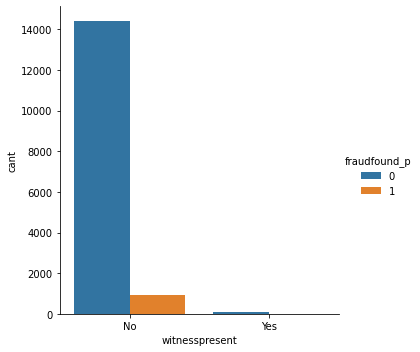

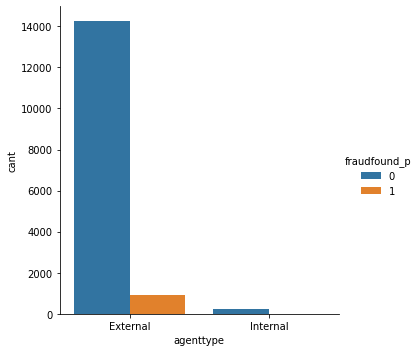

In [20]:
variables = ['policereportfiled', 'witnesspresent', 'agenttype']
plt.figure(figsize=(20,70))
for i,var in enumerate(variables):
    dfgraf = df.groupby(['fraudfound_p',var]).size().reset_index().rename({0:'cant'},axis=1)
    dfgraf = pd.DataFrame(dfgraf)
    sns.catplot(data=dfgraf, kind="bar", x=var, y= 'cant', hue="fraudfound_p")
    plt.show()

### Comentarios a nivel general sobre las variables analizadas

Algunas variables están desequilibradas por ejemplo para las variables con dos categorías:

* accidentarea: Mas del 85% de los accidentes ha sido en área rural.
* sex: el 84% de los registros corresponde a hombres.
* fault: el 73% de los accidentes corresponde al dueño de la póliza
* FraudFound_P: solo el 6% de los registros presentan un incidente fraudulento.
* deductible: el 96% de los clientes pago por el seguro 400.
* PoliceReportFiled:  el 97% de los casos los accidentes no han sido denunciados por la policía.
* WitnessPresent: el 99% de los casos no hay testigos del accidente.
* agenttype: el 98% de los casos se ha relacionado un externo de la empresa con los casos de fraude.
  

Para las variables con mas de dos categorías:

* make: Marca del vehículo las marcas: Accura, Ford, VW, Dodge, Saab, Mercury, Saturn,Nisson, BMW, Jaguar, Porche, Mecedes, Ferrari, Lexus tenían menos del 10% de los registros.
* dayofweekclaimed: De los días de la semana en los que se hace la denuncia solo el 18% ocurre los fines de semana (entre viernes y domingo) y hay un registro sin dato.
* MonthClaimed: Hay un registro que contiene un 0
* marital estatus: El 69% están casados, el 30% son solteros y menos del 1% son viudos o divorciados.
* age: La mayoría de las edades de las personas que hacen la denuncia se encuentran entre los 21 y 65 años, solo el 5% tienen menos de 25 años, el 3% tiene más de 65 años y el 6% corresponde a  320 personas no tiene registrada la edad.
* policy type, el 95% de los accidentes están relacionados con vehículos tipo sedan (Sedan - All Perils, Sedan - Collision, Sedan - Liability) y solo el 4% esta relacionado con vehículos sport y utility
* vehicleprice: el 25% de los vehículos costó más de 40,000
* **repnumber**: esta variable tienen muchas categorías y parece no ser de interés así que se descarta
* Days_Policy_Accident: los días que han pasado entre adquirir el seguro y el accidente en un 98% son mas de 90 días y menos del 1% (55) no tienen registros.
* days_policy_claim: el 99% tienen más de 30 días, solo 1 persona no tiene registro (eliminar a este sr tiene cero en casi todo)
* ageofvehicle: el 14% de los vehículos accidentados tienen 5 años o menos.
* ageofpolicyholder: La mayor concentración de edades de los dueños de la póliza está entre los 31 y 50 años con el 81%, el 7% de l tiene menos de 30 años y el 12% tiene más de 50.
* **NumberOfSuppliments**: El 45% de los casos  se tiene registros nulos de datos no reportados al realizar la denuncia 
* **addresschange_claim:** Más del 80% no ha reportado cambios de dirección
* **numberofcars** en mas del 80% de los accidentes solo hay un vehículo involucrado

# Construcción del modelo

Para la construcción del modelo la variable de respuesta y es **FraudFound_P**

* La variable age como tiene valores nulos estos serán reemplazados por la moda
* Las variables repnumber, NumberOfSuppliments, addresschange_claim por lo mencionado anteriormente no serán tenidas en cuenta en el modelo
* Se descartan las variables 'policereportfiled', 'witnesspresent', 'agenttype', en esta primera verisón ya que parece no tener mucha relación con la variable de interés 

Aunque hay otras variables desbalanceadas se tendrán en cuenta ya que tienen relación directa con el usuario y se piensan que son de interés, sin embargo seria necesario tomar acciones como: Hablar con un experto, evaluar métodos de desbalanceo para las variables dependientes y probar modelos agregando y quitando diferentes variables. Finalmente para esta primera versión se tienen en cuenta 26 variables de las 32 iniciales.

Se cescarta este registro ya que en la mayoria de las columnas presenta datos faltantes

In [21]:
## obtener los valores nulos para reemplzarlos luego
df.replace({'none': np.NaN}, inplace=True)
df['age'] = df['age'].replace({0: np.NaN})
df[['dayofweekclaimed', 'monthclaimed']] = df[[
            'dayofweekclaimed', 'monthclaimed']].replace({'0': np.NaN})


In [22]:
# eliminar columnas
df.drop(['repnumber','numberofsuppliments', 'addresschange_claim','policereportfiled', 'witnesspresent', 'agenttype'], axis=1, inplace=True)


In [33]:
# Get dummies para las variables categoricas
tipos_object = df.loc[:, df.columns].dtypes
categorical_names = tipos_object[tipos_object == object].index
numeric_var = tipos_object[tipos_object != object].index


In [36]:
from sklearn.impute import SimpleImputer

In [37]:
# valores categoricos en nulos se reemplazan por la moda
categorical_transformer = SimpleImputer(strategy='most_frequent')


idf = pd.DataFrame(categorical_transformer.fit_transform(df))

categorical_transformer.fit(df[categorical_names])

idf.columns=df.columns
idf.index=df.index

df = idf


In [38]:
train_data = pd.get_dummies(
    df, columns=categorical_names, drop_first=True)


# renombrando la variable de respuesta
train_data = train_data.rename(
            columns={'fraudfound_p_1': 'fraudfound_p'})  

print(train_data.shape)  

(15420, 119)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

In [86]:
#  # creando variables categoricas y nocategoricas get dummies
# tipos = train_data.loc[:, train_data.columns != 'fraudfound_p'].dtypes
# numeric_var = tipos[tipos != object].index
# categorical_var = tipos[tipos == object].index

In [41]:
# tratamiento a las valores perdidos en las variables categoricas y numericas

# categorical_transformer = Pipeline(steps=[
#     ('transfor_vars', SimpleImputer(strategy='most_frequent'))]
# )

numeric_transformer = Pipeline(steps=[
    ('transfor_vars', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())]
)

pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[
                                    ('num', numeric_transformer, numeric_var)
                                ]
                                )

In [42]:
X = train_data.drop(['fraudfound_p'], axis=1)
y = train_data['fraudfound_p']
nombresX = X.columns

X_prepro = pre_process.fit_transform(X) 

X_prepro = pd.DataFrame(X_prepro, columns= nombresX)
X_prepro.head()

,age,monthh_Aug,monthh_Dec,monthh_Feb,monthh_Jan,monthh_Jul,monthh_Jun,monthh_Mar,monthh_May,monthh_Nov,monthh_Oct,monthh_Sep,weekofmonth_2,weekofmonth_3,weekofmonth_4,weekofmonth_5,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,make_BMW,make_Chevrolet,make_Dodge,make_Ferrari,make_Ford,make_Honda,make_Jaguar,make_Lexus,make_Mazda,make_Mecedes,make_Mercury,make_Nisson,make_Pontiac,make_Porche,make_Saab,make_Saturn,make_Toyota,make_VW,accidentarea_Urban,dayofweekclaimed_Monday,dayofweekclaimed_Saturday,dayofweekclaimed_Sunday,dayofweekclaimed_Thursday,dayofweekclaimed_Tuesday,dayofweekclaimed_Wednesday,monthclaimed_Aug,monthclaimed_Dec,monthclaimed_Feb,monthclaimed_Jan,monthclaimed_Jul,monthclaimed_Jun,monthclaimed_Mar,monthclaimed_May,monthclaimed_Nov,monthclaimed_Oct,monthclaimed_Sep,weekofmonthclaimed_2,weekofmonthclaimed_3,weekofmonthclaimed_4,weekofmonthclaimed_5,sex_Male,maritalstatus_Married,maritalstatus_Single,maritalstatus_Widow,fault_Third Party,policytype_Sedan - Collision,policytype_Sedan - Liability,policytype_Sport - All Perils,policytype_Sport - Collision,policytype_Sport - Liability,policytype_Utility - All Perils,policytype_Utility - Collision,policytype_Utility - Liability,vehiclecategory_Sport,vehiclecategory_Utility,vehicleprice_30000 to 39000,vehicleprice_40000 to 59000,vehicleprice_60000 to 69000,vehicleprice_less than 20000,vehicleprice_more than 69000,deductible_400,deductible_500,deductible_700,driverrating_2,driverrating_3,driverrating_4,days_policy_accident_15 to 30,days_policy_accident_8 to 15,days_policy_accident_more than 30,days_policy_claim_8 to 15,days_policy_claim_more than 30,pastnumberofclaims_2 to 4,pastnumberofclaims_more than 4,ageofvehicle_3 years,ageofvehicle_4 years,ageofvehicle_5 years,ageofvehicle_6 years,ageofvehicle_7 years,ageofvehicle_more than 7,ageofvehicle_new,ageofpolicyholder_18 to 20,ageofpolicyholder_21 to 25,ageofpolicyholder_26 to 30,ageofpolicyholder_31 to 35,ageofpolicyholder_36 to 40,ageofpolicyholder_41 to 50,ageofpolicyholder_51 to 65,ageofpolicyholder_over 65,numberofcars_2 vehicles,numberofcars_3 to 4,numberofcars_5 to 8,numberofcars_more than 8,yearr_1995,yearr_1996,basepolicy_Collision,basepolicy_Liability
0,-1.586717,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.527726,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.531265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.997561,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X_prepro, y, test_size=0.2, random_state=123)

print("Tamanio del x test:", X_test.shape)
print("Tamanio del y test:", y_test.shape)

print("Tamanio del X train:", X_train.shape)
print("Tamanio del y train:", y_train.shape)

Tamanio del x test: (3084, 118)
Tamanio del y test: (3084,)
Tamanio del X train: (12336, 118)
Tamanio del y train: (12336,)


# Definición de los modelos a aplicar

Para el cumplimiento del objetivo de reducir pérdidas por fraudes en las reclamaciones de siniestros, se plantea un modelo de clasificación con el fin de poder clasificar un clientes en el caso de que cometa fraude.

Para la generación del modelo predictivo de fraudes, se prueban los siguientes métodos:
* Regresión logística 
* Random Forest
* KNN
* Support Vector Machine (SVM)
* Gaussian Naive Bayes (GNB)
* Xgboost

Se elige el modelo que genere las mejores métricas y los menores tiempos de ejecución.

In [44]:
oversample = SMOTE(sampling_strategy='auto', random_state=123)
nombres = X.columns

X_res, y_res = oversample.fit_resample(X_train, y_train)
X_res = pd.DataFrame(X_res, columns= nombres)


print("Tamanio del X train:", X_res.shape)
print("Tamanio del y train:", y_res.shape)

Tamanio del X train: (23206, 118)
Tamanio del y train: (23206,)


Implementacion de los algoritmos de clasificacion

In [48]:
## funcion para aplicar los diferentes metodos de clasificacion
## con kfold 
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
             ('LogReg', LogisticRegression()),
             ('RF', RandomForestClassifier()),
              ('KNN', KNeighborsClassifier()),
             ('SVM', SVC()), 
             ('GNB', GaussianNB()),
            ('XGB', XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['No', 'Si']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names= target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [49]:
df_metodos = run_exps(X_res, y_res.values.ravel(), X_test, y_test.values.ravel())

/home/yarangodev/Documentos/GrupoR5/r5-ds-challenge_LMgarzon/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yarangodev/Documentos/GrupoR5/r5-ds-challenge_LMgarzon/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

LogReg
              precision    recall  f1-score   support

          No       0.98      0.68      0.80      2894
          Si       0.14      0.77      0.23       190

    accuracy                           0.68      3084
   macro avg       0.56      0.72      0.52      3084
weighted avg       0.93      0.68      0.77      3084

RF
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      2894
          Si       0.50      0.01      0.01       190

    accuracy                           0.94      3084
   macro avg       0.72      0.50      0.49      3084
weighted avg       0.91      0.94      0.91      3084

KNN
              precision    recall  f1-score   support

          No       0.96      0.63      0.77      2894
          Si       0.10      0.63      0.18       190

    accuracy                           0.63      3084
   macro avg       0.53      0.63      0.47      3084
weighted avg       0.91      0.63      0.73      3084

SVM
 

In [79]:
df_metodos.head()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.442373,0.050430,0.790177,0.806084,0.790177,0.787373,0.851705,LogReg
1,0.446434,0.051819,0.803964,0.818050,0.803964,0.801522,0.860428,LogReg
2,0.407645,0.051471,0.784145,0.801365,0.784145,0.780446,0.848303,LogReg
3,0.410631,0.050058,0.781560,0.797094,0.781560,0.778323,0.839540,LogReg
4,0.460576,0.051204,0.792331,0.812345,0.792331,0.789580,0.852259,LogReg


In [50]:
## bootstraps 
bootstraps = []

for model in list(set(df_metodos.model.values)):
    model_df = df_metodos.loc[df_metodos.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)

In [51]:
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

In [52]:
## Metricas
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # obtener el dataframe sin los fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

In [53]:
## tiempo de las metricas
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # data frame con los fit data
results_long_fit = results_long_fit.sort_values(by='values')
results_long_fit

,model,metrics,values
331,GNB,score_time,0.006830
346,GNB,score_time,0.006926
335,GNB,score_time,0.006926
338,GNB,score_time,0.006926
339,GNB,score_time,0.006926
...,...,...,...
121,SVM,fit_time,9.001755
129,SVM,fit_time,9.001755
120,SVM,fit_time,9.001755
130,SVM,fit_time,9.001755


Observando las métricas de cada modelo, se encontró que el algoritmo XGBoost Y Random Forest presentaron las mejores métricas de clasificación, aunque los promedios de las métricas de XGBoost son más altos que los de RF.

Text(0.5, 1.0, 'Comparación de los modelos por metrica de clasificacion')

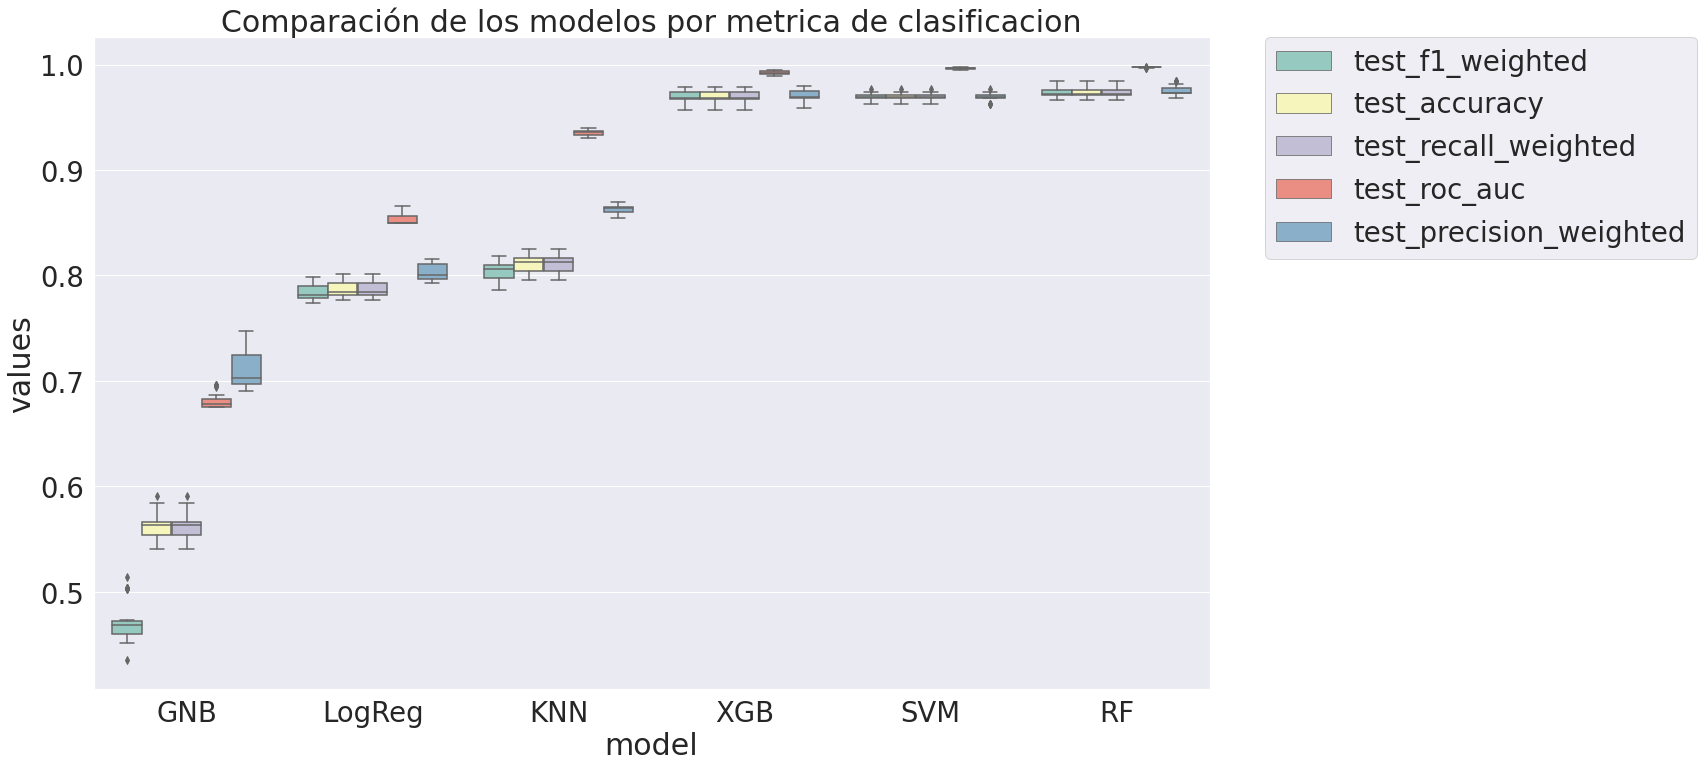

In [54]:
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparación de los modelos por metrica de clasificacion')
#plt.savefig('./img/boxplot_metricas_clasificacion.png',dpi=300)

Text(0.5, 1.0, 'Comparación del modelo por Fit y Score Time')

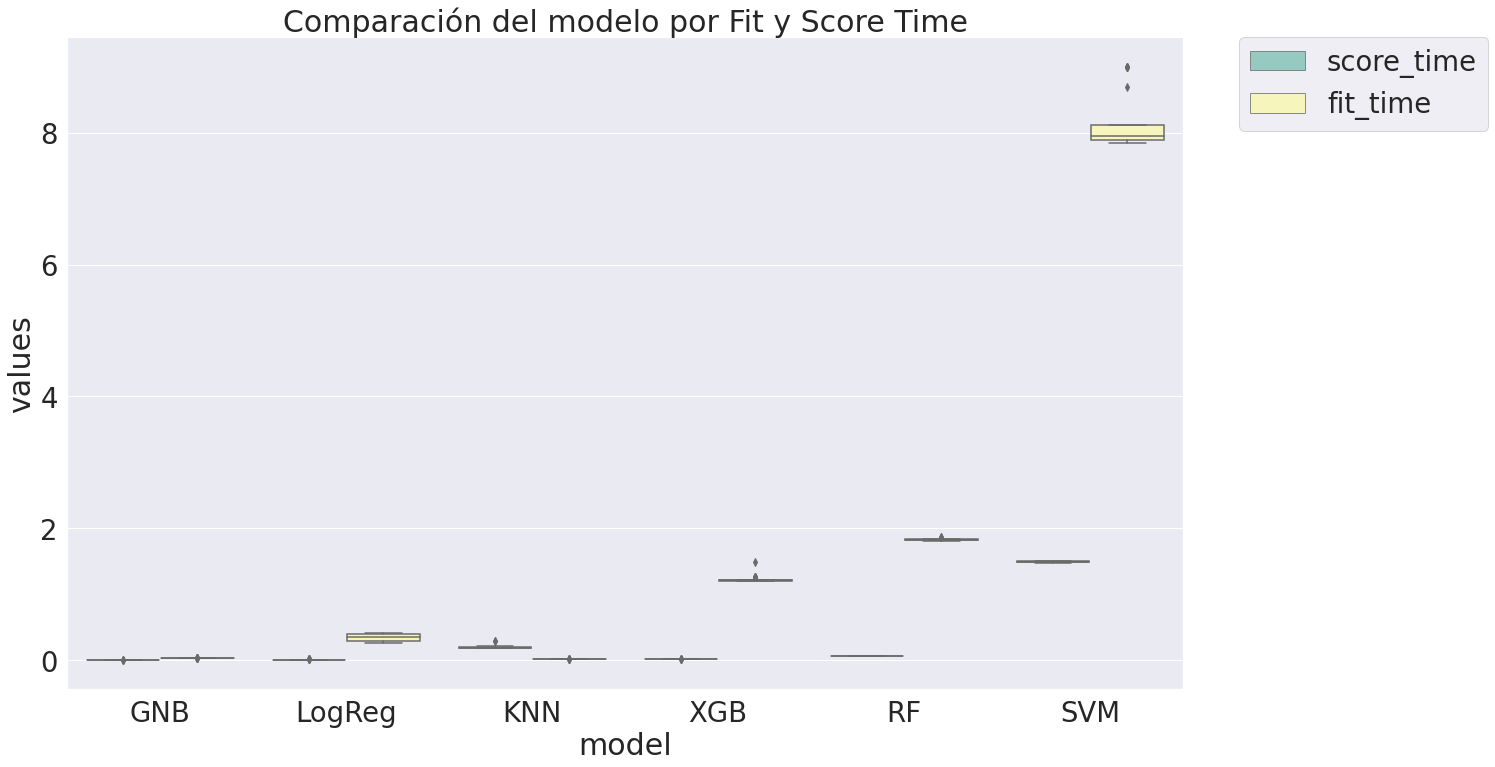

In [56]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparación del modelo por Fit y Score Time')
#plt.savefig('./img/boxplot_tiempos_modelos.png',dpi=300)

In [57]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_recall_weighted           test_roc_auc           test_f1_weighted  \
                        std      mean          std      mean              std   
model                                                                           
GNB                0.011963  0.564940     0.007468  0.680957         0.020340   
KNN                0.008387  0.810182     0.002976  0.935382         0.009146   
LogReg             0.007764  0.787524     0.005729  0.854038         0.007741   
RF                 0.004955  0.974071     0.000428  0.997341         0.004964   
SVM                0.003379  0.969305     0.000763  0.996089         0.003379   
XGB                0.005274  0.969607     0.001804  0.992008         0.005284   

                 test_precision_weighted           test_accuracy            
            mean                     std      mean           std      mean  
model                                                                       
GNB     0.471985                0.018262  0.709890      0.011963  0.564940  
KNN     0.802824                0.004215  0.862266      0.008387  0.810182  
LogReg  0.784884                0.008110  0.802485      0.007764  0.787524  
RF      0.974053                0.004532  0.975330      0.004955  0.974071  
SVM     0.969305                0.003378  0.969324      0.003379  0.969305  
XGB     0.969587                0.004861  0.970778      0.005274  0.969607

In [58]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time           score_time          
             std      mean        std      mean
model                                          
GNB     0.001404  0.027423   0.000263  0.007155
KNN     0.001479  0.015173   0.023982  0.199109
LogReg  0.056393  0.344460   0.002248  0.009363
RF      0.016008  1.823867   0.000532  0.068673
SVM     0.418701  8.151460   0.009077  1.489405
XGB     0.053649  1.229658   0.000760  0.013951

### Modelo elegido

In [59]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=90210)
model =  XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False)

In [60]:
model.fit(X_res,y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

aaaa

importancia de variables


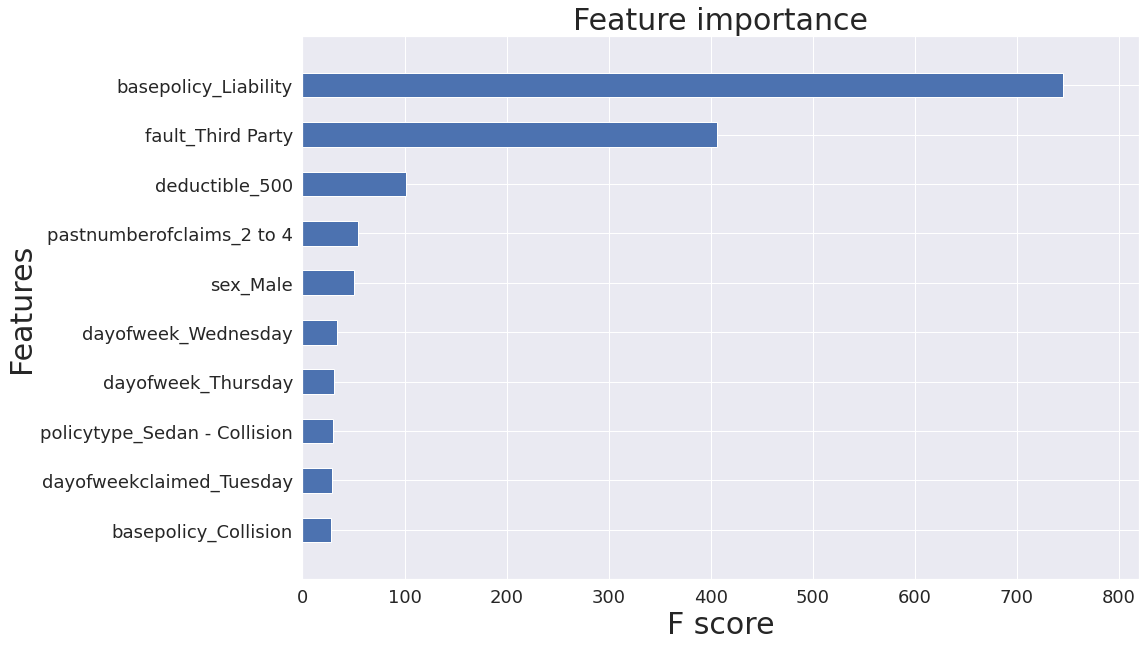

In [61]:
#Importance variable
print('importancia de variables')
ax = xgb.plot_importance(model, max_num_features =10, importance_type='gain',height=0.5,show_values=False)
fig = ax.figure
fig.set_size_inches(15, 10)
plt.tick_params(labelsize = 18)

In [62]:
## predicciones
y_pred_proba = model.fit(X_res,y_res).predict_proba(X_test)[:,1]
y_train_pred = model.fit(X_res,y_res).predict(X_res)
y_test_pred=model.fit(X_res,y_res).predict(X_test)

print('matríz de confusion en entrenamiento')
cf_matrix = confusion_matrix(y_res, y_train_pred)
print(cf_matrix)

print('matríz de confusion en test')
cf_matrix = confusion_matrix(y_test, y_test_pred)
print(cf_matrix)

print('métricas en entrenamiento')
print(classification_report(y_res,y_train_pred))

print('métricas en test')
print(classification_report(y_test,y_test_pred))

matríz de confusion en entrenamiento
[[11601     2]
 [  350 11253]]
matríz de confusion en test
[[2880   14]
 [ 178   12]]
métricas en entrenamiento
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     11603
           1       1.00      0.97      0.98     11603

    accuracy                           0.98     23206
   macro avg       0.99      0.98      0.98     23206
weighted avg       0.99      0.98      0.98     23206

métricas en test
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.46      0.06      0.11       190

    accuracy                           0.94      3084
   macro avg       0.70      0.53      0.54      3084
weighted avg       0.91      0.94      0.91      3084



Index(['monthh', 'weekofmonth', 'dayofweek', 'make', 'accidentarea',
       'dayofweekclaimed', 'monthclaimed', 'weekofmonthclaimed', 'sex',
       'maritalstatus', 'fault', 'policytype', 'vehiclecategory',
       'vehicleprice', 'deductible', 'driverrating', 'days_policy_accident',
       'days_policy_claim', 'pastnumberofclaims', 'ageofvehicle',
       'ageofpolicyholder', 'numberofcars', 'yearr', 'basepolicy'],
      dtype='object')